# 03. Baseline Models Training & Evaluation

## Goal
- Load preprocessed data (Train & OOD) from Google Drive.
- Train 4 Baseline Models on Dataset A (2014-2016):
    1. Logistic Regression
    2. Random Forest
    3. XGBoost
    4. LightGBM
- Evaluate standard metrics on Train (In-Distribution) vs OOD (Shift).
- Save metrics and models to Drive.

In [11]:
!pip install xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import joblib

%matplotlib inline

In [13]:
# --- DRIVE SETUP ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/credit_risk_project'
    DATA_DIR = os.path.join(PROJECT_DIR, 'data/processed')
    RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
    MODELS_DIR = os.path.join(RESULTS_DIR, 'models')
    TABLES_DIR = os.path.join(RESULTS_DIR, 'tables')
    FIGURES_DIR = os.path.join(RESULTS_DIR, 'figures')
    
    for d in [MODELS_DIR, TABLES_DIR, FIGURES_DIR]:
        os.makedirs(d, exist_ok=True)
        
except ImportError:
    # Local fallback
    PROJECT_DIR = '..'
    DATA_DIR = '../data/processed'
    RESULTS_DIR = '../results'

print(f"Project Dir: {PROJECT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project Dir: /content/drive/MyDrive/credit_risk_project


In [14]:
# Load Preprocessed Data
try:
    df_train = pd.read_pickle(os.path.join(DATA_DIR, 'train_final.pkl'))
    df_ood = pd.read_pickle(os.path.join(DATA_DIR, 'ood_final.pkl'))
    print("Loaded final processed data.")
except FileNotFoundError:
    print("Error: Processed files not found. Run Notebook 02 first.")

Loaded final processed data.


In [15]:
# Separate X and y
target_col = 'target'

if target_col not in df_train.columns:
    print(f"Error: Target column '{target_col}' not found!")
else:
    X_train = df_train.drop(target_col, axis=1)
    y_train = df_train[target_col]

    X_ood = df_ood.drop(target_col, axis=1)
    y_ood = df_ood[target_col]

    print(f"Train Features: {X_train.shape}")
    print(f"OOD Features: {X_ood.shape}")

Train Features: (891754, 37)
OOD Features: (56318, 37)


In [16]:
# Define Models
# Using valid parameters. Note: n_jobs=-1 uses all cores. 

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1),
    'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, n_jobs=-1, eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, n_jobs=-1, random_state=42, verbose=-1)
}

In [17]:
# Evaluation Function
def evaluate_model(model, X, y, name, dataset_name):
    start = time.time()
    y_pred = model.predict(X)
    try:
        y_prob = model.predict_proba(X)[:, 1]
    except:
        y_prob = y_pred # Fallback if probability not supported
        
    end = time.time()
    
    metrics = {
        'Model': name,
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y, y_pred),
        'AUC': roc_auc_score(y, y_prob),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0),
        'Inference_Time': end - start
    }
    return metrics

# Training Loop
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Save Model
    model_path = os.path.join(MODELS_DIR, f'{name}.pkl')
    joblib.dump(model, model_path)
    
    print(f"Evaluating {name}...")
    res_train = evaluate_model(model, X_train, y_train, name, 'In-Distribution (Train)')
    res_ood = evaluate_model(model, X_ood, y_ood, name, 'Out-of-Distribution (Shift)')
    
    results.append(res_train)
    results.append(res_ood)

df_res = pd.DataFrame(results)
print("Training Complete.")

Training LogisticRegression...
Evaluating LogisticRegression...
Training RandomForest...
Evaluating RandomForest...
Training XGBoost...
Evaluating XGBoost...
Training LightGBM...
Evaluating LightGBM...
Training Complete.


                Model                      Dataset  Accuracy       AUC  \
0  LogisticRegression      In-Distribution (Train)  0.796268  0.716434   
1  LogisticRegression  Out-of-Distribution (Shift)  0.829024  0.686248   
2        RandomForest      In-Distribution (Train)  0.797944  0.729052   
3        RandomForest  Out-of-Distribution (Shift)  0.839785  0.697010   
4             XGBoost      In-Distribution (Train)  0.798475  0.726889   
5             XGBoost  Out-of-Distribution (Shift)  0.836908  0.698139   
6            LightGBM      In-Distribution (Train)  0.797858  0.724366   
7            LightGBM  Out-of-Distribution (Shift)  0.836908  0.698520   

   Precision    Recall        F1  Inference_Time  
0   0.545938  0.113536  0.187980        0.297113  
1   0.358561  0.107843  0.165815        0.015878  
2   0.620812  0.069831  0.125541       10.500567  
3   0.428708  0.050485  0.090332        0.494143  
4   0.588347  0.099002  0.169485        3.104698  
5   0.409646  0.079446  0.1

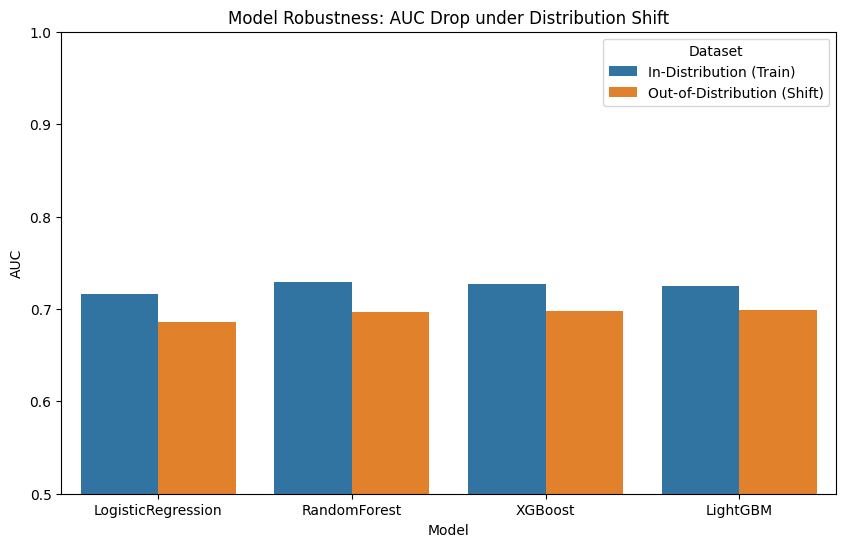

In [18]:
# Display Results
print(df_res)

# Save Results Table to Drive
df_res.to_csv(os.path.join(TABLES_DIR, 'model_performance.csv'), index=False)

# Visualization of AUC Drop
plt.figure(figsize=(10, 6))
sns.barplot(data=df_res, x='Model', y='AUC', hue='Dataset')
plt.title('Model Robustness: AUC Drop under Distribution Shift')
plt.ylim(0.5, 1.0)
plt.savefig(os.path.join(FIGURES_DIR, 'auc_comparison.png'))
plt.show()

In [19]:
print(f"Models saved to: {MODELS_DIR}")
print(f"Results saved to: {TABLES_DIR}")
print("Proceed to Notebook 04_evaluation.ipynb")

Models saved to: /content/drive/MyDrive/credit_risk_project/results/models
Results saved to: /content/drive/MyDrive/credit_risk_project/results/tables
Proceed to Notebook 04_evaluation.ipynb
